In [49]:
import sys
sys.path.append('../')
import time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
from scipy.optimize import brute
# import cv2
import torch
import json
import csv
from functions.all_knots_functions import *
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import collections
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [50]:
hyperparams = {
    # 'learning_rate': 5e-4,  # Control dropout rate
    'learning_rate': 5e-4,  # Control dropout rate
    'patience': 4,  # Number of epochs between learning rate decay
    'factor': 0.2,  # Multiplicative factor of learning rate decay
    'batch_size': 64
}

num_epochs = 100
print_every = 1

hidden_sizes1 = 128
hidden_sizes2 = 1024
hidden_sizes3 = 128
num_hidden = 5
hidden_sizes1 = 128
hidden_sizes2 = 1024
hidden_sizes3 = 128
num_hidden = 10

In [51]:
knot_types = {
        'standard_16': 0,  # 1
        'standard_14': 1,  # 2
        'standard_18': 2,  # 3
        '30both': 3,  # 4
        '30oneZ': 4,  # 5
        'optimized': 5,  # 6
        'pm_03_z': 6,  # 7
        # '4foil': hopf_4foil,  # 8
        # '6foil': hopf_6foil,  # 9
        # 'stand4foil': hopf_stand4foil,  # 10
        '30oneX': 7,  # 11
        '15oneZ': 8,
        'dennis': 9,
        'trefoil_standard_12': 10,
        'trefoil_optimized': 11,
        # 'fivefoil_standard_08': fivefoil_standard_08

}


knots = [
    'standard_14', 'standard_16', 'standard_18', '30both', '30oneZ',
    'optimized', 'pm_03_z', '30oneX', '15oneZ', 'dennis',
    'trefoil_standard_12', 'trefoil_optimized'
]


folder = '../HOPFS_L270_5e-07_test_1s'
#


num_classes = len(knots)
X_list = []
Y_list = []
csv.field_size_limit(10000000)

Xs_list = []
Ys_list = []
for knot in knots:

    # filename = f'../../../{folder}/data_{knot}_spectr.csv'
    filename = f'../DATA/{folder}/data_{knot}_spectr.csv'

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            Ys_list.append(knot_types[knot])
            data_array = json.loads(row[0])
            l1, l2 = data_array[0], data_array[1]
            p1, p2 = data_array[2], data_array[3]

            moments = np.array([x[0] + 1j * x[1] for x in data_array[5:]]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            moments = moments / np.sqrt(np.sum(np.abs(moments) ** 2))
            Xs_list.append(np.abs(moments.reshape(-1)))


In [52]:
Xs_np = np.array(Xs_list)
ys_np = np.array(Ys_list)
# print(ys_np.shape)
Xs_torch = torch.tensor(Xs_np).float()
ys_t = torch.tensor(ys_np)
ys_torch = F.one_hot(ys_t.long(), num_classes=num_classes).float()
print(Xs_torch.shape, ys_torch.shape)

torch.Size([120, 91]) torch.Size([120, 12])


In [53]:
X_train, X_val_test, y_train, y_val_test = train_test_split(Xs_torch, ys_torch, test_size=0.3, random_state=37)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=37)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

In [54]:

class ClassifierFC_spec(nn.Module):
    def __init__(self, input_size, hidden_sizes1, hidden_sizes2, hidden_sizes3, num_hidden, num_classes):
        super(ClassifierFC_spec, self).__init__()
        layers = []
        # Create input layer with batch normalization
        layers.append(nn.Linear(input_size, hidden_sizes1, bias=True))
        layers.append(nn.BatchNorm1d(hidden_sizes1))  # Batch normalization
        layers.append(nn.ReLU())

        # Add second layer with batch normalization
        layers.append(nn.Linear(hidden_sizes1, hidden_sizes2, bias=True))
        layers.append(nn.BatchNorm1d(hidden_sizes2))  # Batch normalization
        layers.append(nn.ReLU())

        # Create hidden layers with batch normalization
        for i in range(0, num_hidden):
            layers.append(nn.Linear(hidden_sizes2, hidden_sizes2, bias=True))
            layers.append(nn.BatchNorm1d(hidden_sizes2))  # Batch normalization
            layers.append(nn.ReLU())

        # Create output layers with batch normalization
        layers.append(nn.Linear(hidden_sizes2, hidden_sizes3, bias=True))
        layers.append(nn.BatchNorm1d(hidden_sizes3))  # Batch normalization
        layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_sizes3, num_classes))

        # ModuleList of all layers
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            # print(x.shape)
        return x

In [55]:
# in_channels, out_channels, kernel_size, stride, padding
input_size = Xs_np.shape[-1]

num_classes = ys_torch.shape[-1]
model = ClassifierFC_spec(input_size, hidden_sizes1, hidden_sizes2, hidden_sizes3,
                          num_hidden, num_classes).to(device)

In [56]:
# print(model._to_linear, 512 * 16 * 16)
dots_3d_toch_batch = train_dataset[1:4][0].to(device)
print(dots_3d_toch_batch.shape)
print(model(dots_3d_toch_batch).shape)
summary(model, input_size=dots_3d_toch_batch.shape[1:])

torch.Size([3, 91])
torch.Size([3, 12])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          11,776
       BatchNorm1d-2                  [-1, 128]             256
              ReLU-3                  [-1, 128]               0
            Linear-4                 [-1, 1024]         132,096
       BatchNorm1d-5                 [-1, 1024]           2,048
              ReLU-6                 [-1, 1024]               0
            Linear-7                 [-1, 1024]       1,049,600
       BatchNorm1d-8                 [-1, 1024]           2,048
              ReLU-9                 [-1, 1024]               0
           Linear-10                 [-1, 1024]       1,049,600
      BatchNorm1d-11                 [-1, 1024]           2,048
             ReLU-12                 [-1, 1024]               0
           Linear-13                 [-1, 1024]       1,049,600

In [57]:
train_dataset[1:2][0]

tensor([[4.1268e-05, 9.2048e-06, 2.2688e-05, 4.0826e-05, 1.1647e-05, 1.1790e-05,
         4.0360e-05, 4.1689e-05, 4.6866e-05, 2.2794e-05, 1.5907e-05, 2.4595e-05,
         2.0105e-05, 1.0950e-05, 1.0123e-04, 9.2503e-05, 1.5549e-04, 5.2605e-04,
         7.1910e-04, 5.1503e-04, 2.3232e-04, 2.8603e-04, 2.1098e-04, 4.2122e-05,
         1.4799e-05, 1.7364e-05, 1.1074e-05, 2.9892e-06, 1.3264e-04, 7.3408e-05,
         4.9150e-05, 2.0864e-05, 4.2571e-05, 1.0078e-04, 3.3557e-05, 6.0224e-04,
         9.7455e-04, 4.6750e-04, 8.5639e-05, 5.1533e-05, 4.9194e-05, 3.1033e-05,
         2.9542e-01, 6.2199e-01, 4.7465e-01, 3.9016e-04, 2.9611e-04, 7.9058e-04,
         1.0393e-03, 7.3636e-04, 4.8502e-04, 5.3223e-04, 2.4001e-05, 6.4716e-05,
         3.9744e-05, 2.3625e-05, 5.4823e-01, 3.1966e-04, 1.1929e-04, 6.8139e-05,
         2.5291e-05, 1.2715e-04, 5.6412e-05, 8.5233e-04, 2.2097e-04, 9.0431e-05,
         5.4412e-05, 2.7821e-05, 1.8702e-05, 1.8370e-06, 8.6446e-05, 6.2592e-05,
         1.9772e-04, 4.8430e

In [58]:
def loop_train(model, train_loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    for i, (inputs, targets) in enumerate(train_loader, 1):  # Start enumeration from 1
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # Clear the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
        total_loss += loss.item()  # Accumulate the loss

    return total_loss / len(train_loader)  # Return the average loss


def loop_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track the gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute the loss
            total_loss += loss.item()  # Accumulate the loss
    return total_loss / len(test_loader)  # Return the average loss


def correct_number_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total = 0
    with torch.no_grad():  # No need to track the gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            correct = criterion(outputs, targets)  # Compute correct
            total_correct += correct  # Accumulate correct
            total += len(outputs)  # Accumulate total
    return total_correct, total  # Return the average loss


def plot_losses(train_losses, test_losses, decimals=3):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses,
             label=f'Train Loss {train_losses[-1]: .{decimals}f} (min: {min(train_losses): .{decimals}f})')
    plt.plot(test_losses, label=f'Test Loss {test_losses[-1]: .{decimals}f} (min: {min(test_losses): .{decimals}f})')
    plt.title('Training and Testing Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [59]:

# criterion = nn.MSELoss().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=hyperparams['factor'], patience=hyperparams['patience'],
                              verbose=True)



train_losses = []
val_losses = []
train_loader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparams['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=hyperparams['batch_size'])
start_time = time.time()
for epoch in trange(num_epochs, desc="Progress"):
    epoch_start_time = time.time()
    train_losses.append(loop_train(model, train_loader, criterion, optimizer))
    val_losses.append(loop_test(model, val_loader, criterion))

    scheduler.step(val_losses[-1])

    if (epoch + 1) % print_every == 0:
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch} completed in {epoch_time:.2f} seconds')
        print(f'Epoch {epoch}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


total_training_time = time.time() - start_time
print(f'Total training time: {total_training_time:.2f} seconds')

Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 completed in 0.04 seconds
Epoch 0: Train Loss: 2.3788, Val Loss: 2.5149
Epoch 1 completed in 0.03 seconds
Epoch 1: Train Loss: 1.5426, Val Loss: 2.5216
Epoch 2 completed in 0.03 seconds
Epoch 2: Train Loss: 0.8888, Val Loss: 2.5270


Progress:   4%|▍         | 4/100 [00:00<00:02, 35.80it/s]

Epoch 3 completed in 0.02 seconds
Epoch 3: Train Loss: 0.7147, Val Loss: 2.5311
Epoch 4 completed in 0.03 seconds
Epoch 4: Train Loss: 0.5643, Val Loss: 2.5371
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 5 completed in 0.02 seconds
Epoch 5: Train Loss: 0.4597, Val Loss: 2.5419
Epoch 6 completed in 0.02 seconds
Epoch 6: Train Loss: 0.4564, Val Loss: 2.5436
Epoch 7 completed in 0.02 seconds
Epoch 7: Train Loss: 0.4245, Val Loss: 2.5458
Epoch 8 completed in 0.02 seconds
Epoch 8: Train Loss: 0.4263, Val Loss: 2.5435


Progress:   9%|▉         | 9/100 [00:00<00:02, 39.53it/s]

Epoch 9 completed in 0.02 seconds
Epoch 9: Train Loss: 0.6016, Val Loss: 2.5514
Epoch 00011: reducing learning rate of group 0 to 2.0000e-05.
Epoch 10 completed in 0.03 seconds
Epoch 10: Train Loss: 0.3786, Val Loss: 2.5635
Epoch 11 completed in 0.02 seconds
Epoch 11: Train Loss: 0.8294, Val Loss: 2.5848
Epoch 12 completed in 0.02 seconds
Epoch 12: Train Loss: 0.7902, Val Loss: 2.6465


Progress:  14%|█▍        | 14/100 [00:00<00:02, 40.35it/s]

Epoch 13 completed in 0.03 seconds
Epoch 13: Train Loss: 0.4009, Val Loss: 2.6598
Epoch 14 completed in 0.03 seconds
Epoch 14: Train Loss: 0.4418, Val Loss: 2.6800
Epoch 00016: reducing learning rate of group 0 to 4.0000e-06.
Epoch 15 completed in 0.02 seconds
Epoch 15: Train Loss: 0.6017, Val Loss: 2.6894
Epoch 16 completed in 0.03 seconds
Epoch 16: Train Loss: 0.4174, Val Loss: 2.7232
Epoch 17 completed in 0.02 seconds
Epoch 17: Train Loss: 0.4108, Val Loss: 2.7514


Progress:  19%|█▉        | 19/100 [00:00<00:02, 40.49it/s]

Epoch 18 completed in 0.02 seconds
Epoch 18: Train Loss: 0.5463, Val Loss: 2.7878
Epoch 19 completed in 0.02 seconds
Epoch 19: Train Loss: 0.3737, Val Loss: 2.7858
Epoch 00021: reducing learning rate of group 0 to 8.0000e-07.
Epoch 20 completed in 0.02 seconds
Epoch 20: Train Loss: 0.3951, Val Loss: 2.7915
Epoch 21 completed in 0.02 seconds
Epoch 21: Train Loss: 0.4391, Val Loss: 2.7956


Progress:  24%|██▍       | 24/100 [00:00<00:01, 41.52it/s]

Epoch 22 completed in 0.02 seconds
Epoch 22: Train Loss: 0.4259, Val Loss: 2.7750
Epoch 23 completed in 0.02 seconds
Epoch 23: Train Loss: 0.4819, Val Loss: 2.7820
Epoch 24 completed in 0.02 seconds
Epoch 24: Train Loss: 0.3683, Val Loss: 2.7509
Epoch 00026: reducing learning rate of group 0 to 1.6000e-07.
Epoch 25 completed in 0.02 seconds
Epoch 25: Train Loss: 0.3846, Val Loss: 2.7126
Epoch 26 completed in 0.02 seconds

Progress:  29%|██▉       | 29/100 [00:00<00:01, 41.32it/s]


Epoch 26: Train Loss: 0.3856, Val Loss: 2.6708
Epoch 27 completed in 0.02 seconds
Epoch 27: Train Loss: 0.3661, Val Loss: 2.6177
Epoch 28 completed in 0.02 seconds
Epoch 28: Train Loss: 0.4773, Val Loss: 2.5669
Epoch 29 completed in 0.02 seconds
Epoch 29: Train Loss: 0.4096, Val Loss: 2.4707
Epoch 30 completed in 0.02 seconds
Epoch 30: Train Loss: 0.8620, Val Loss: 2.3846
Epoch 31 completed in 0.02 seconds
Epoch 31: Train Loss: 0.8844, Val Loss: 2.3482


Progress:  34%|███▍      | 34/100 [00:00<00:01, 42.35it/s]

Epoch 32 completed in 0.02 seconds
Epoch 32: Train Loss: 0.3595, Val Loss: 2.2768
Epoch 33 completed in 0.02 seconds
Epoch 33: Train Loss: 0.4459, Val Loss: 2.1522
Epoch 34 completed in 0.02 seconds
Epoch 34: Train Loss: 0.4900, Val Loss: 1.9939
Epoch 35 completed in 0.02 seconds
Epoch 35: Train Loss: 0.4961, Val Loss: 1.8492


Progress:  39%|███▉      | 39/100 [00:00<00:01, 43.04it/s]

Epoch 36 completed in 0.02 seconds
Epoch 36: Train Loss: 0.3853, Val Loss: 1.7755
Epoch 37 completed in 0.02 seconds
Epoch 37: Train Loss: 0.4166, Val Loss: 1.6493
Epoch 38 completed in 0.02 seconds
Epoch 38: Train Loss: 0.4927, Val Loss: 1.5855
Epoch 39 completed in 0.02 seconds
Epoch 39: Train Loss: 0.5469, Val Loss: 1.4463
Epoch 40 completed in 0.02 seconds
Epoch 40: Train Loss: 0.3626, Val Loss: 1.2688
Epoch 41 completed in 0.02 seconds
Epoch 41: Train Loss: 0.3931, Val Loss: 1.1241


Progress:  44%|████▍     | 44/100 [00:01<00:01, 44.12it/s]

Epoch 42 completed in 0.02 seconds
Epoch 42: Train Loss: 0.6723, Val Loss: 0.9714
Epoch 43 completed in 0.02 seconds
Epoch 43: Train Loss: 0.3847, Val Loss: 0.8651
Epoch 44 completed in 0.02 seconds
Epoch 44: Train Loss: 0.4247, Val Loss: 0.7633
Epoch 45 completed in 0.02 seconds
Epoch 45: Train Loss: 0.7065, Val Loss: 0.6630


Progress:  49%|████▉     | 49/100 [00:01<00:01, 44.13it/s]

Epoch 46 completed in 0.03 seconds
Epoch 46: Train Loss: 0.4458, Val Loss: 0.5852
Epoch 47 completed in 0.02 seconds
Epoch 47: Train Loss: 0.3709, Val Loss: 0.5619
Epoch 48 completed in 0.02 seconds
Epoch 48: Train Loss: 0.6900, Val Loss: 0.5121
Epoch 49 completed in 0.02 seconds
Epoch 49: Train Loss: 0.3638, Val Loss: 0.5126
Epoch 50 completed in 0.02 seconds
Epoch 50: Train Loss: 0.4007, Val Loss: 0.4774


Progress:  54%|█████▍    | 54/100 [00:01<00:01, 43.56it/s]

Epoch 51 completed in 0.02 seconds
Epoch 51: Train Loss: 0.5208, Val Loss: 0.4623
Epoch 52 completed in 0.03 seconds
Epoch 52: Train Loss: 0.6509, Val Loss: 0.4703
Epoch 53 completed in 0.02 seconds
Epoch 53: Train Loss: 0.4151, Val Loss: 0.4641
Epoch 54 completed in 0.03 seconds
Epoch 54: Train Loss: 0.4902, Val Loss: 0.4666
Epoch 55 completed in 0.02 seconds
Epoch 55: Train Loss: 0.3751, Val Loss: 0.4709


Progress:  59%|█████▉    | 59/100 [00:01<00:00, 43.41it/s]

Epoch 00057: reducing learning rate of group 0 to 3.2000e-08.
Epoch 56 completed in 0.02 seconds
Epoch 56: Train Loss: 0.4880, Val Loss: 0.4796
Epoch 57 completed in 0.02 seconds
Epoch 57: Train Loss: 0.3810, Val Loss: 0.4832
Epoch 58 completed in 0.02 seconds
Epoch 58: Train Loss: 0.5121, Val Loss: 0.4913
Epoch 59 completed in 0.02 seconds
Epoch 59: Train Loss: 0.4953, Val Loss: 0.4812


Progress:  64%|██████▍   | 64/100 [00:01<00:00, 44.59it/s]

Epoch 60 completed in 0.02 seconds
Epoch 60: Train Loss: 0.3774, Val Loss: 0.4907
Epoch 00062: reducing learning rate of group 0 to 6.4000e-09.
Epoch 61 completed in 0.02 seconds
Epoch 61: Train Loss: 0.5460, Val Loss: 0.4916
Epoch 62 completed in 0.02 seconds
Epoch 62: Train Loss: 0.7580, Val Loss: 0.4695
Epoch 63 completed in 0.02 seconds
Epoch 63: Train Loss: 0.3976, Val Loss: 0.4741
Epoch 64 completed in 0.02 seconds
Epoch 64: Train Loss: 0.4367, Val Loss: 0.4811
Epoch 65 completed in 0.02 seconds
Epoch 65: Train Loss: 0.4237, Val Loss: 0.4871
Epoch 66 completed in 0.02 seconds
Epoch 66: Train Loss: 0.5116, Val Loss: 0.4565


Progress:  69%|██████▉   | 69/100 [00:01<00:00, 45.33it/s]

Epoch 67 completed in 0.02 seconds
Epoch 67: Train Loss: 0.3475, Val Loss: 0.4671
Epoch 68 completed in 0.02 seconds
Epoch 68: Train Loss: 0.4162, Val Loss: 0.4758
Epoch 69 completed in 0.02 seconds
Epoch 69: Train Loss: 0.4134, Val Loss: 0.4737


Progress:  74%|███████▍  | 74/100 [00:01<00:00, 45.86it/s]

Epoch 70 completed in 0.02 seconds
Epoch 70: Train Loss: 0.3892, Val Loss: 0.4712
Epoch 71 completed in 0.02 seconds
Epoch 71: Train Loss: 0.3727, Val Loss: 0.4779
Epoch 72 completed in 0.02 seconds
Epoch 72: Train Loss: 0.6019, Val Loss: 0.4691
Epoch 73 completed in 0.02 seconds
Epoch 73: Train Loss: 0.3980, Val Loss: 0.4828
Epoch 74 completed in 0.02 seconds
Epoch 74: Train Loss: 0.3541, Val Loss: 0.4939
Epoch 75 completed in 0.02 seconds
Epoch 75: Train Loss: 0.3755, Val Loss: 0.4889
Epoch 76 completed in 0.02 seconds
Epoch 76: Train Loss: 0.6456, Val Loss: 0.4968


Progress:  79%|███████▉  | 79/100 [00:01<00:00, 46.10it/s]

Epoch 77 completed in 0.02 seconds
Epoch 77: Train Loss: 0.4021, Val Loss: 0.5093
Epoch 78 completed in 0.02 seconds
Epoch 78: Train Loss: 0.4066, Val Loss: 0.4959
Epoch 79 completed in 0.02 seconds
Epoch 79: Train Loss: 0.3584, Val Loss: 0.4966


Progress:  84%|████████▍ | 84/100 [00:01<00:00, 45.80it/s]

Epoch 80 completed in 0.03 seconds
Epoch 80: Train Loss: 0.4014, Val Loss: 0.4999
Epoch 81 completed in 0.02 seconds
Epoch 81: Train Loss: 0.3488, Val Loss: 0.5113
Epoch 82 completed in 0.02 seconds
Epoch 82: Train Loss: 0.6677, Val Loss: 0.5511
Epoch 83 completed in 0.02 seconds
Epoch 83: Train Loss: 0.6072, Val Loss: 0.5234
Epoch 84 completed in 0.02 seconds
Epoch 84: Train Loss: 0.4385, Val Loss: 0.5024
Epoch 85 completed in 0.03 seconds
Epoch 85: Train Loss: 0.4548, Val Loss: 0.4867
Epoch 86 completed in 0.02 seconds
Epoch 86: Train Loss: 0.3813, Val Loss: 0.4981


Progress:  89%|████████▉ | 89/100 [00:02<00:00, 45.56it/s]

Epoch 87 completed in 0.02 seconds
Epoch 87: Train Loss: 0.4270, Val Loss: 0.5044
Epoch 88 completed in 0.02 seconds
Epoch 88: Train Loss: 0.4248, Val Loss: 0.4981
Epoch 89 completed in 0.02 seconds
Epoch 89: Train Loss: 0.3981, Val Loss: 0.4996


Progress:  94%|█████████▍| 94/100 [00:02<00:00, 45.88it/s]

Epoch 90 completed in 0.02 seconds
Epoch 90: Train Loss: 0.3966, Val Loss: 0.4989
Epoch 91 completed in 0.02 seconds
Epoch 91: Train Loss: 0.5896, Val Loss: 0.4943
Epoch 92 completed in 0.02 seconds
Epoch 92: Train Loss: 0.5050, Val Loss: 0.4942
Epoch 93 completed in 0.02 seconds
Epoch 93: Train Loss: 0.3960, Val Loss: 0.4876
Epoch 94 completed in 0.02 seconds
Epoch 94: Train Loss: 0.4151, Val Loss: 0.4955
Epoch 95 completed in 0.02 seconds
Epoch 95: Train Loss: 0.4211, Val Loss: 0.4883
Epoch 96 completed in 0.02 seconds
Epoch 96: Train Loss: 0.4576, Val Loss: 0.4877
Epoch 97 completed in 0.02 seconds
Epoch 97: Train Loss: 0.3377, Val Loss: 0.4977


Progress:  99%|█████████▉| 99/100 [00:02<00:00, 46.37it/s]

Epoch 98 completed in 0.02 seconds
Epoch 98: Train Loss: 0.4064, Val Loss: 0.5031
Epoch 99 completed in 0.02 seconds
Epoch 99: Train Loss: 0.3567, Val Loss: 0.5090


Progress: 100%|██████████| 100/100 [00:02<00:00, 44.00it/s]

Total training time: 2.27 seconds


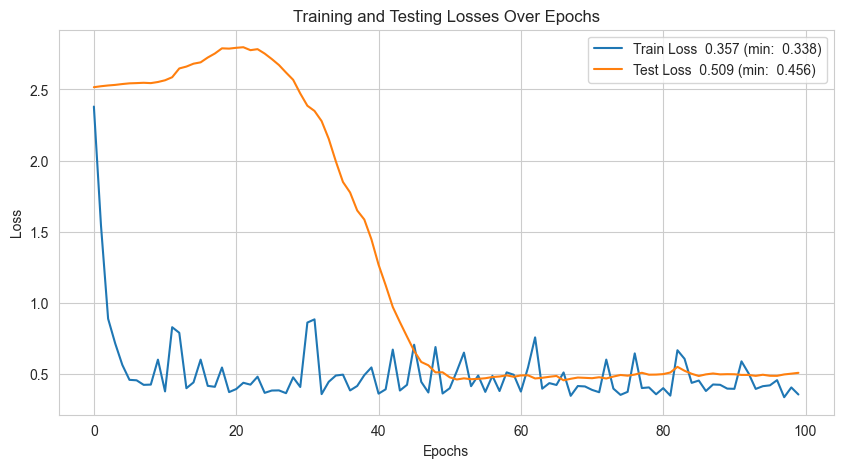

In [60]:
plot_losses(train_losses, val_losses, decimals=3)

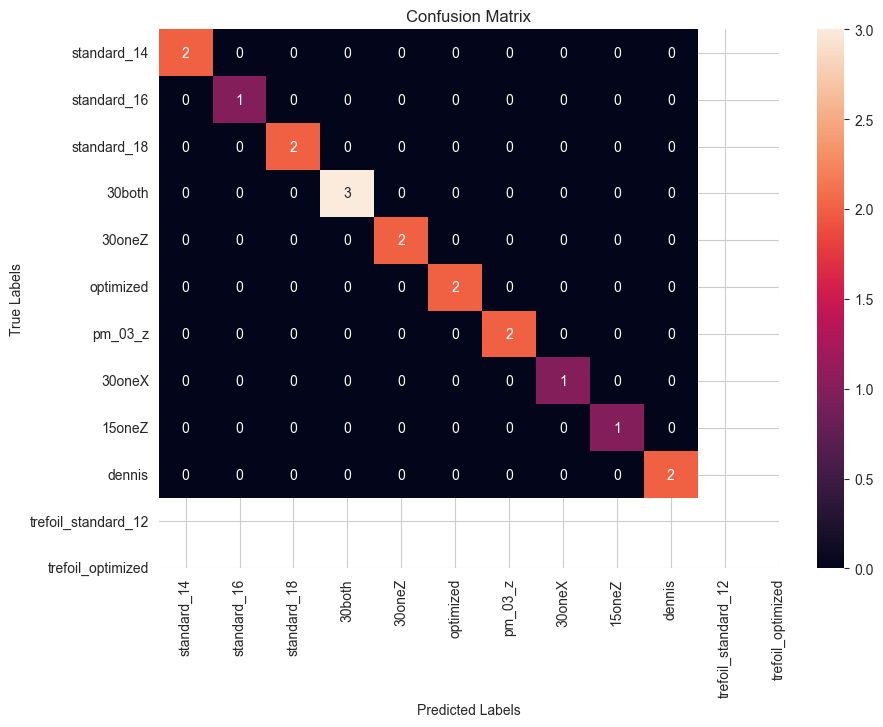

In [61]:
# predictions = model(X_torch.to(device))
# predictions
model.eval()  # Set the model to evaluation mode
predicted_labels = []
with torch.no_grad():  # Disable gradient calculation
    for batch in test_loader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
# Convert the list to a numpy array
predicted_labels = np.array(predicted_labels)
# If you need the result as a tensor, convert back to tensor
predicted_labels = torch.tensor(predicted_labels)

# _, predicted_labels = torch.max(model(X_test.to(device)), 1)
_, true_class_labels = torch.max(y_test, 1)
predicted_labels_np = predicted_labels.cpu().numpy()
true_labels_np = true_class_labels.cpu().numpy()
cm = confusion_matrix(true_labels_np, predicted_labels_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [62]:
Accuracy = (np.sum(predicted_labels_np == true_labels_np)) / len(predicted_labels_np)
print(Accuracy)

1.0


In [63]:
def criterion_correct(predictions, labels):
    _, predicted_labels = torch.max(predictions, 1)
    _, true_class_labels = torch.max(labels, 1)
    # print(predicted_labels)
    # print(y_torch)
    correct_predictions = torch.sum(predicted_labels == true_class_labels).item()
    return correct_predictions


correct_predictions, total = correct_number_test(model, test_loader, criterion_correct)
print(f"Number of correct predictions (test): {correct_predictions}/{total}")

correct_predictions, total = correct_number_test(model, val_loader, criterion_correct)
print(f"Number of correct predictions (val): {correct_predictions}/{total}")

Number of correct predictions (test): 18/18
Number of correct predictions (val): 18/18


Creating the least of the weights in 2D as a basis

In [64]:
def build_weights(weights, ls, ps, l1, l2, p1, p2):
    weights_ar = np.zeros(((l2 - l1 + 1), (p2 - p1 + 1)), dtype=complex)
    for l, p, weight in zip(ls, ps, weights):
        weights_ar[l - l1, p - p1] = weight
    return weights_ar

# getting the dimensions
filename = f'..\\{folder}\\data_{knots[0]}_spectr.csv'
with open(filename, 'r') as file:
    reader = csv.reader(file)
    row = next(iter(reader))
    data_list = json.loads(row[0])
    # Convert the list back to a NumPy array if needed
    # print(data_list)
    # data_array = np.array(data_list)
    data_array = data_list

    l1, l2 = data_array[0], data_array[1]
    p1, p2 = data_array[2], data_array[3]
print(l1, l2, p1, p2)

values_basis = []
for knot in knots:
# for knot in ['6foil']:
    print(knot)
    with open(f'..\\{folder}\\{knot}.pkl', 'rb') as file:

        file = pickle.load(file)
        ls = file['l']
        ps = file['p']
        weights = file['weight']
        values = build_weights(weights, ls, ps, l1, l2, p1, p2)
        values = values / np.sqrt(np.sum(np.abs(values) ** 2))
        values_basis.append(values)
        # plt.imshow(np.abs(values).T[::-1])
        # plt.colorbar()
        # plt.show()

print(len(values_basis), values_basis[0].shape)

FileNotFoundError: [Errno 2] No such file or directory: '..\\../HOPFS_L270_5e-07_test_1s\\data_standard_14_spectr.csv'

In [ ]:
# Function to calculate MSE
def calculate_mse(array1, array2):
    return ((np.abs(array1) - np.abs(array2)) ** 2).mean()

closest_basis_knots = []
true_labels = []
for knot in knots:
    closest_basis_knot = []
    true_label = []
# for knot in ['6foil']:
    filename = f'..\\{folder}\\data_{knot}_spectr.csv'

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            true_label.append(knot_types[knot])
            data_array = json.loads(row[0])

            # indx = data_array[4]
            # field = np.load(f'..\\{folder}\\fields\\data_{knot}_{indx}.npy')
            # plt.imshow(np.abs(field ))
            # plt.show()

            moments = np.array([x[0] + 1j * x[1] for x in data_array[5:]]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            moments = moments / np.sqrt(np.sum(np.abs(moments) ** 2))
            mse_scores = [calculate_mse(moments, values) for values in values_basis]
            closest_basis_knot.append(np.argmin(mse_scores))
            # plt.imshow(np.abs(moments))
            # plt.colorbar()
            # plt.show()
    true_labels.append(true_label)
    closest_basis_knots.append(closest_basis_knot)

# print(len(closest_basis_knots), len(closest_basis_knots[0]), print(closest_basis_knots[0]))
# print(true_labels)
# print(closest_basis_knots)


In [ ]:
predicted_labels_spec_np = np.array(closest_basis_knots).reshape(-1)
true_labels_spec_np = np.array(true_labels).reshape(-1)
# print(true_labels_spec_np)
cm = confusion_matrix(true_labels_spec_np, predicted_labels_spec_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# def build_weights(weights, ls, ps, l1, l2, p1, p2):
#     weights_ar = np.zeros(((l2 - l1 + 1), (p2 - p1 + 1)), dtype=complex)
#     for l, p, weight in zip(ls, ps, weights):
#         weights_ar[l - l1, p - p1] = weight
#     return weights_ar
#
# # getting the dimensions
# filename = f'..\\{folder}\\data_{knots[0]}_spectr.csv'
# with open(filename, 'r') as file:
#     reader = csv.reader(file)
#     row = next(iter(reader))
#     data_list = json.loads(row[0])
#     # Convert the list back to a NumPy array if needed
#     # print(data_list)
#     # data_array = np.array(data_list)
#     data_array = data_list
#
#     l1, l2 = data_array[0], data_array[1]
#     p1, p2 = data_array[2], data_array[3]
# print(l1, l2, p1, p2)

knots_basis = []
knots_basis_dots = []
for knot in knots:
# for knot in ['6foil']:
    filename = f'..\\data_basis\\data_{knot}.csv'

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Deserialize the JSON string back to a list
            data_list = json.loads(row[0])
            # Convert the list back to a NumPy array if needed
            data_array = np.array(data_list)
            points_list = data_array[2:]

            Nx, Ny, Nz = data_array[1]
            if desired_res != (Nx, Ny, Nz):
                scale_x = desired_res[0] / Nx
                scale_y = desired_res[1] / Ny
                scale_z = desired_res[2] / Nz
                points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)
            knots_basis_dots.append(points_list)
            # Initialize a 3D array with zeros
            dots_3d = np.zeros(desired_res, dtype=int)
            # Set the specified coordinates to 1
            for x, y, z in points_list:
                try: dots_3d[x, y, z] = 1
                except IndexError: continue
            knots_basis.append(dots_3d)

print(len(knots_basis), knots_basis[0].shape)
print(len(knots_basis_dots), knots_basis_dots[0].shape,knots_basis_dots[0][0])
print(knots_basis_dots[0].shape, knots_basis_dots[3].shape)

In [ ]:
# Function to calculate MSE
def calculate_mse_knot(array1, array2):
    return ((array1 - array2) ** 2).mean()

def calculate_mse_knot_dots(array1, dots):
    # loss = -np.sum([np.array(array1)[np.array(dot)] for dot in dots])
    loss = -np.sum([array1[tuple(dot)] for dot in dots])

    return loss

closest_knots = []
closest_knots_dots = []
true_knots = []
j = -1
for i, x in enumerate(X_torch):
    j += 1
    true_knots.append(torch.argmax(y_torch[i]).item())

    mse_scores = [calculate_mse_knot(x[0], knot_) for knot_ in knots_basis]
    closest_knots.append(np.argmin(mse_scores))

    mse_scores_dots = [calculate_mse_knot_dots(x[0], dots_) for dots_ in knots_basis_dots]
    # print(mse_scores_dots)
    # min_indices = np.where(mse_scores_dots == np.min(mse_scores_dots))[0]
    # if len(min_indices) > 1:
    #     result = 0
    # else:
    #     result = min_indices[0]
    closest_knots_dots.append(np.argmin(mse_scores_dots))
    # plt.imshow(knots_basis[j][:, :, 8])
    # plt.colorbar()
    # plt.show()
    # plt.imshow(x[0][:, :, 8])
    # plt.colorbar()
    # plt.show()
    # break


# print(len(closest_basis_knots), len(closest_basis_knots[0]), print(closest_basis_knots[0]))
# print(true_labels)
# print(closest_basis_knots)


In [ ]:

predicted_labels_spec_np = np.array(closest_knots).reshape(-1)
true_labels_spec_np = np.array(true_knots).reshape(-1)
# print(true_labels_spec_np)
cm = confusion_matrix(true_labels_spec_np, predicted_labels_spec_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

predicted_labels_spec_np = np.array(closest_knots_dots).reshape(-1)
true_labels_spec_np = np.array(true_knots).reshape(-1)
# print(true_labels_spec_np)
cm = confusion_matrix(true_labels_spec_np, predicted_labels_spec_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:


X_list_sp = []
Y_list_sp = []
for knot in knots:
# for knot in ['6foil']:
    filename = f'..\\{folder}\\data_{knot}_spectr.csv'
    with open(f'..\\{folder}\\{knot}.pkl', 'rb') as file:
        file = pickle.load(file)
        ls = file['l']
        ps = file['p']
        weights = file['weight']
        for row in reader:
                # Deserialize the JSON string back to a list
                data_list = json.loads(row[0])
                # Convert the list back to a NumPy array if needed
                # print(data_list)
                # data_array = np.array(data_list)
                data_array = data_list

                l1, l2 = data_array[0], data_array[1]
                p1, p2 = data_array[2], data_array[3]

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Deserialize the JSON string back to a list
            data_list = json.loads(row[0])
            # Convert the list back to a NumPy array if needed
            # print(data_list)
            # data_array = np.array(data_list)
            data_array = data_list

            l1, l2 = data_array[0], data_array[1]
            p1, p2 = data_array[2], data_array[3]
            indx = data_array[4]
            field = np.load(f'..\\{folder}\\fields\\data_{knot}_{indx}.npy')
            plt.imshow(np.abs(field ))
            plt.show()

            # print(f'l1, l2, p1, p2: {l1}, {l2}, {p1}, {p2} ({(l2 - l1 + 1) * (p2 - p1 + 1)})')
            # moments = np.array(data_array[4:]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            moments = np.array([x[0] + 1j * x[1] for x in data_array[5:]]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            # plt.imshow(np.abs(moments).T[::-1, :])
            # plt.show()
            values = build_weights(weights, ls, ps, l1, l2, p1, p2)
            print(f"{knot}")
            plt.imshow(np.abs(values))
            plt.colorbar()
            plt.show()
            plt.imshow(np.abs(moments))
            plt.colorbar()
            plt.show()
            # plt.imshow(np.real(moments).T[::-1, :])
            # plt.show()
            print(moments)
            break
            # continue
            # points_list = data_array[2:]
            # Nx, Ny, Nz = data_array[1]
            # if desired_res != (Nx, Ny, Nz):
            #     scale_x = desired_res[0] / Nx
            #     scale_y = desired_res[1] / Ny
            #     scale_z = desired_res[2] / Nz
            #     points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)
            # # Initialize a 3D array with zeros
            # dots_3d = np.zeros(desired_res, dtype=int)
            # # Set the specified coordinates to 1
            # for x, y, z in points_list:
            #     try: dots_3d[x, y, z] = 1
            #     except IndexError: continue
            # X_list.append(dots_3d)
            # # X_list.append(data_array)
            # Y_list.append(knot_types[knot])
    break

In [ ]:
X_np = np.array(X_list)
y_np = np.array(Y_list)
X_torch = torch.tensor(X_np).reshape(-1,1, *desired_res).float()
# X_torch = torch.tensor(X_np).float()
y_torch_list = torch.tensor(y_np)
y_torch = F.one_hot(y_torch_list.long(), num_classes=num_classes).float()
print(X_torch.shape, y_torch.shape)
X_train, X_val_test, y_train, y_val_test = train_test_split(X_torch, y_torch, test_size=0.3, random_state=37)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=37)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)